In [1]:
import pandas as pd
import numpy as np
import os
import yfinance as yf
import itertools
import warnings
import functions as func
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import shapiro
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import seaborn as sns

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ValueWarning)


In [2]:
DATA_PATH = "tsm_data.json"

if os.path.exists(DATA_PATH):
    
    with open(DATA_PATH) as f:
        tsm_hist = pd.read_json(DATA_PATH)
else:
    tsm = yf.Ticker("TSM")
    tsm_hist = tsm.history(period="max")

    tsm_hist.to_json(DATA_PATH)

In [4]:
tsm_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1997-10-09 04:00:00,2.869037,3.334833,2.869037,3.213321,10201979,0.0,0.0
1997-10-10 04:00:00,3.564356,3.577858,3.233574,3.361836,10669148,0.0,0.0
1997-10-13 04:00:00,3.368587,3.368587,3.274078,3.287579,3044363,0.0,0.0
1997-10-14 04:00:00,3.260575,3.267325,3.064805,3.152564,2549907,0.0,0.0
1997-10-15 04:00:00,2.956795,3.071557,2.950045,3.064806,3167153,0.0,0.0
...,...,...,...,...,...,...,...
2024-04-09 04:00:00,146.259995,148.169998,142.949997,145.399994,18488000,0.0,0.0
2024-04-10 04:00:00,146.630005,148.429993,145.259995,146.220001,18861300,0.0,0.0
2024-04-11 04:00:00,147.199997,147.559998,144.130005,147.199997,11818800,0.0,0.0
2024-04-12 04:00:00,145.000000,146.509995,142.149994,142.520004,11981400,0.0,0.0


<Axes: >

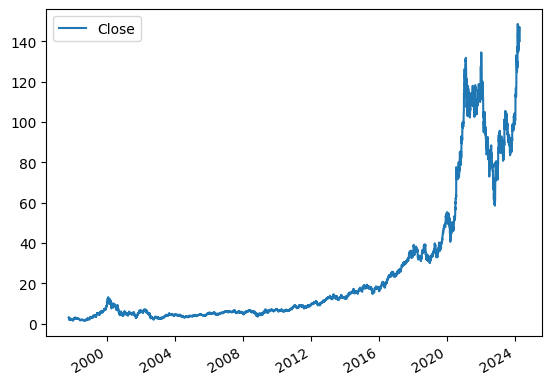

In [5]:
tsm_hist.plot.line(y="Close", use_index=True)

In [7]:
df_tsm = func.calculate_technical_indicators(tsm_hist)

In [8]:
df_tsm_clean = df_tsm.dropna(subset=['rsi'])
df_tsm_clean = df_tsm_clean.drop(columns=['Dividends', 'Stock Splits'])
df_tsm_clean.index = pd.to_datetime(df_tsm_clean.index)
start_date = pd.Timestamp('2020-01-22 05:00:00')
df_tsm_clean = df_tsm_clean[df_tsm_clean.index >= start_date]
df_tsm_clean

,Open,High,Low,Close,Volume,ema_12,ema_26,macd_line,macd_signal,rsi
2020-01-22 05:00:00,54.007056,54.043730,53.475236,53.502743,8124500,53.762937,53.103799,0.659138,0.908278,51.119129
2020-01-23 05:00:00,53.053443,53.245997,51.916451,52.705009,9999200,53.600179,53.074259,0.525920,0.831806,37.326678
2020-01-24 05:00:00,53.264333,53.310179,52.686668,52.934238,10402200,53.497727,53.063887,0.433839,0.752213,48.028672
2020-01-27 05:00:00,50.999517,51.338782,50.486039,50.669422,9675500,53.062603,52.886520,0.176083,0.636987,39.527934
2020-01-28 05:00:00,51.100382,52.374911,50.871150,52.347404,8124400,52.952572,52.846585,0.105987,0.530787,44.444440
...,...,...,...,...,...,...,...,...,...,...
2024-04-09 04:00:00,146.259995,148.169998,142.949997,145.399994,18488000,140.907723,138.104808,2.802914,2.846455,69.696982
2024-04-10 04:00:00,146.630005,148.429993,145.259995,146.220001,18861300,141.724996,138.705934,3.019063,2.880977,68.445671
2024-04-11 04:00:00,147.199997,147.559998,144.130005,147.199997,11818800,142.567304,139.335124,3.232180,2.951218,66.179553
2024-04-12 04:00:00,145.000000,146.509995,142.149994,142.520004,11981400,142.560027,139.571041,2.988987,2.958771,53.594794


<Axes: >

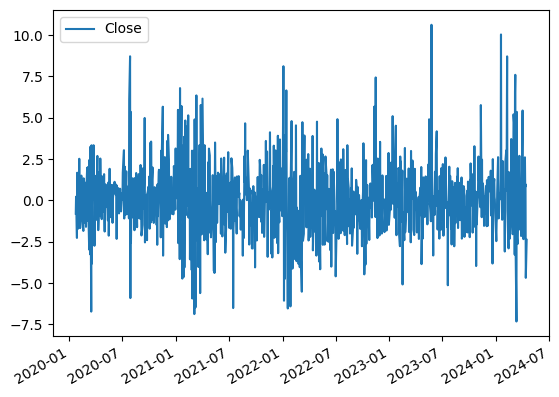

In [9]:
df_close = df_tsm_clean[['Close']].copy()
df_close.index = pd.to_datetime(df_close.index)
start_date = pd.Timestamp('2020-01-22 05:00:00')
df_close = df_close[df_close.index >= start_date]

df_diff = df_close.diff()
df_diff.plot()

In [10]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

stat_test = check_stationarity(df_close)

The series is NOT stationary


In [11]:
df_diff = df_diff.drop(df_diff.index[0])
nan_count = df_diff.isna().sum().sum()
inf_count = np.isinf(df_diff).sum().sum()

print("Number of NaN values in the DataFrame:", nan_count)
print("Number of infinite values in the DataFrame:", inf_count)

Number of NaN values in the DataFrame: 0
Number of infinite values in the DataFrame: 0


In [12]:
def perform_adf_test(ts):
    adf_result = adfuller(ts)
    return adf_result

adf_result = perform_adf_test(df_diff)
print("ADF test statistics:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical values:", adf_result[4])

ADF test statistics: -6.742789021988608
p-value: 3.08839318990451e-09
Critical values: {'1%': -3.43664125006105, '5%': -2.864317735333004, '10%': -2.5682489786730818}


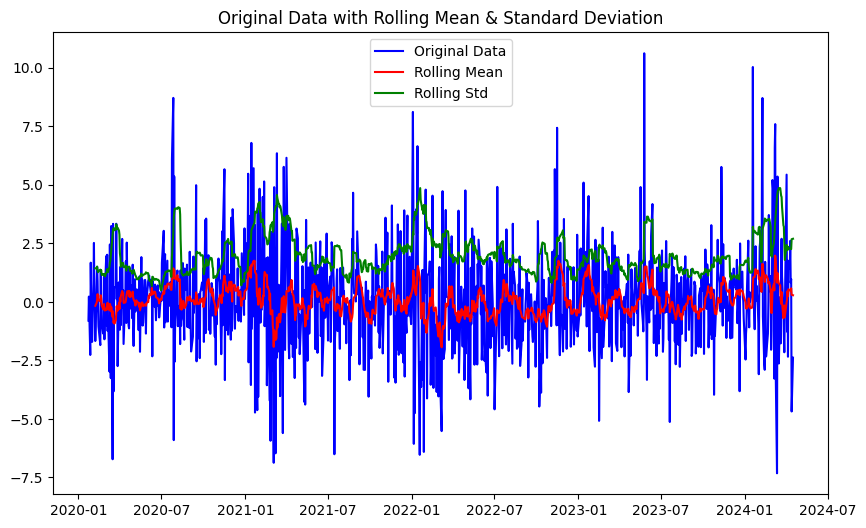

In [13]:
ts = df_diff

plt.figure(figsize=(10, 6))
plt.plot(ts, color='blue', label='Original Data')

rolling_mean = ts.rolling(window=12).mean()
rolling_std = ts.rolling(window=12).std()

plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='green', label='Rolling Std')
plt.title('Original Data with Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

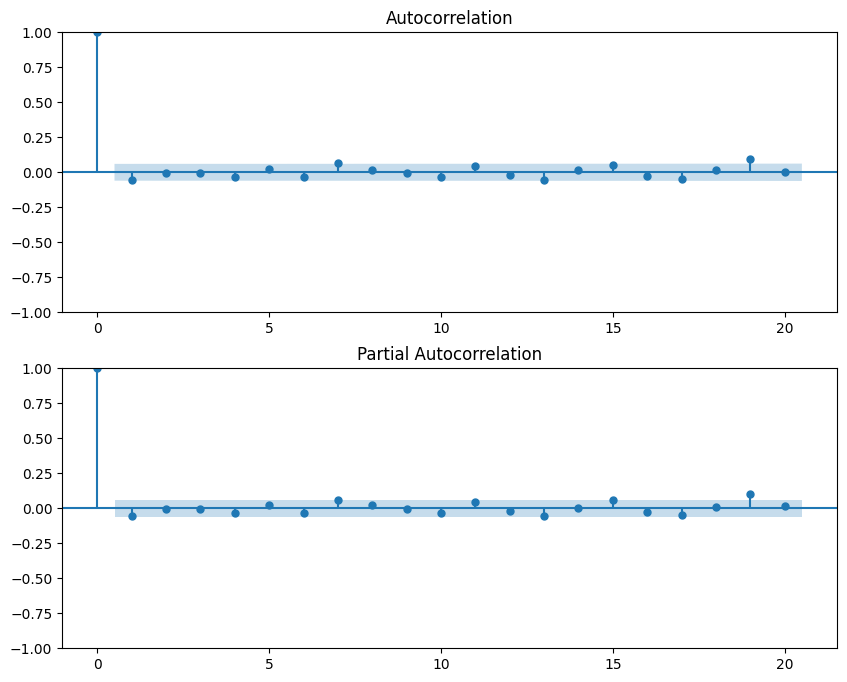

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(ts, ax=axes[0], lags=20)
plot_pacf(ts, ax=axes[1], lags=20)
plt.show()

# ARIMA

In [16]:
df_close.index = pd.to_datetime(df_close.index)
model = auto_arima(df_close, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4652.488, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4648.377, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4646.751, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4646.702, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4647.908, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4648.640, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4648.668, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4645.503, Time=0.43 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4652.397, Time=0.44 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4650.588, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4650.720, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4647.168, Time=1.48 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4645.294, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4648.427, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]          

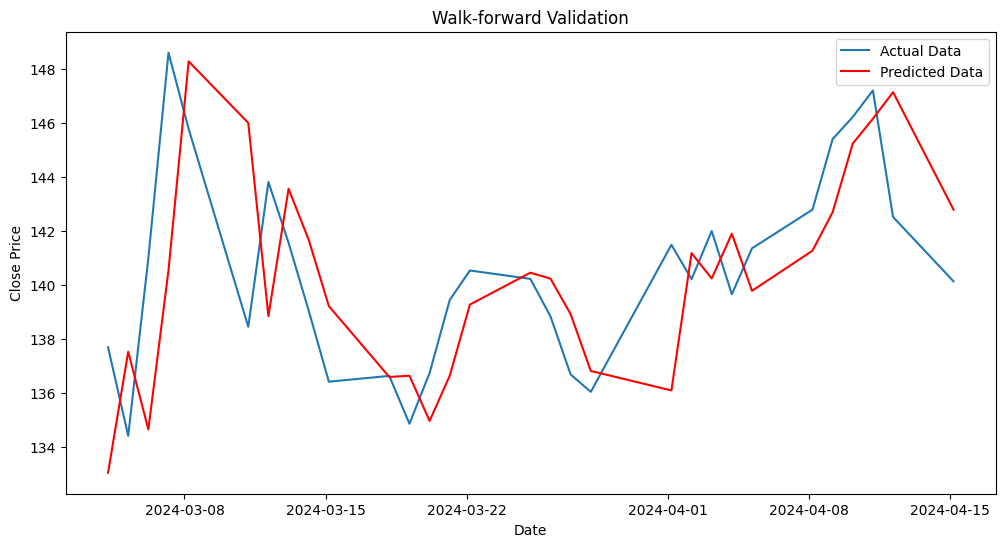

MSE:  11.553467690194932


In [27]:
df_close.index = pd.to_datetime(df_close.index)

df_close = df_close.sort_index()

n_test = 30

history = df_close['Close'].iloc[:-n_test]
predictions = []
actual = list(df_close['Close'].iloc[-n_test:])


for t in range(n_test):
    model = ARIMA(history, order=(0,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output.iloc[0]
    predictions.append(yhat)
    obs = actual[t]
    history = pd.concat([history, pd.Series([obs], index=[df_close.index[len(history)]])])


plt.figure(figsize=(12, 6))
plt.plot(df_close.index[-n_test:], actual, label='Actual Data')
plt.plot(df_close.index[-n_test:], predictions, color='red', label='Predicted Data')
plt.legend()
plt.title("Walk-forward Validation")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual, predictions)
print('MSE: ', mse)

In [96]:
model = ARIMA(df_close, order=(2, 2, 1))
model_fit = model.fit()

forecast = model_fit.forecast(steps=5)
forecast_values_arima = forecast.tolist()
print("Forecasted values for the next 5 points:")
print(forecast)

Forecasted values for the next 5 points:
1065    140.528537
1066    140.726262
1067    140.908068
1068    141.092736
1069    141.277388
Name: predicted_mean, dtype: float64


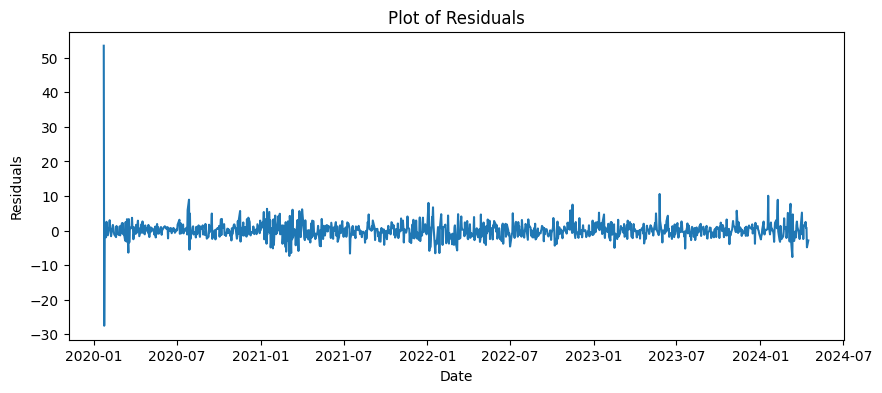

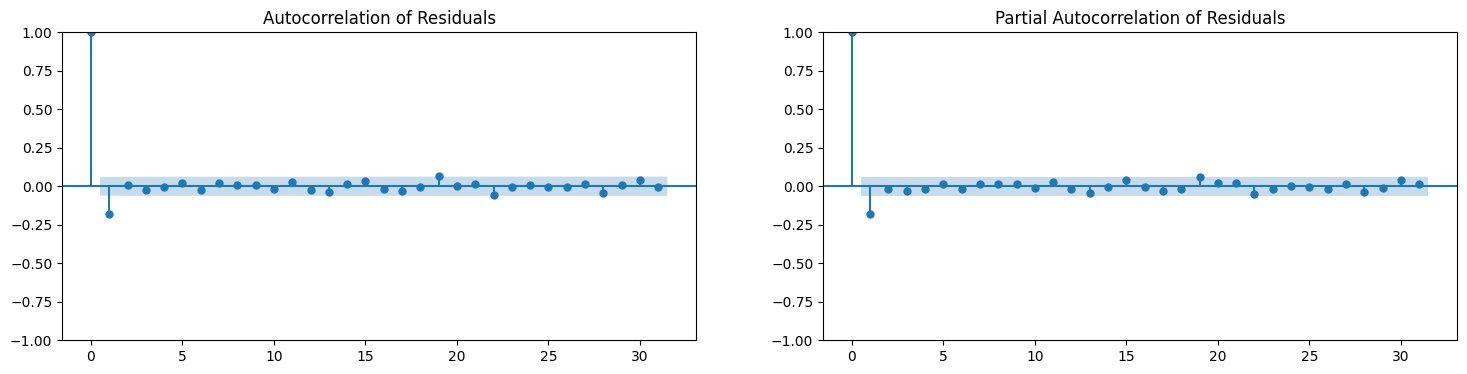

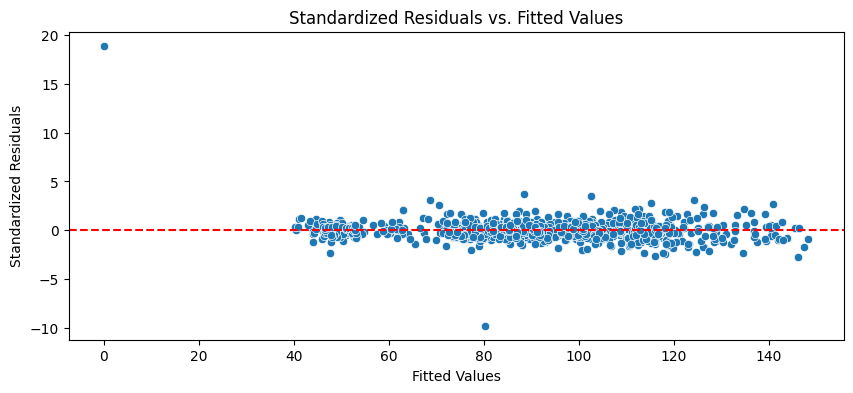

In [29]:
residuals = model_fit.resid

# Plot of residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Plot of Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# ACF and PACF of residuals
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
plot_acf(residuals, ax=ax[0], title='Autocorrelation of Residuals')
plot_pacf(residuals, ax=ax[1], title='Partial Autocorrelation of Residuals')
plt.show()

# Standardized residuals vs. fitted values
fitted_values = model_fit.fittedvalues
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

plt.figure(figsize=(10, 4))
sns.scatterplot(x=fitted_values, y=standardized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Standardized Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')
plt.show()

In [97]:
forecast_result = model_fit.get_forecast(steps=5)

mean_forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

forecast_df = pd.DataFrame({
    'Forecast': mean_forecast,
    'Lower_95%': conf_int.iloc[:, 0],
    'Upper_95%': conf_int.iloc[:, 1]
})
forecast_df.index = pd.date_range(start=df_tsm_clean.index[-1], periods=6, freq=df_tsm_clean.index.freq)[1:]  # Adjust indexing
forecast_df

,Forecast,Lower_95%,Upper_95%
2024-04-16 04:00:00,140.528537,136.323661,144.733413
2024-04-17 04:00:00,140.726262,134.943521,146.509003
2024-04-18 04:00:00,140.908068,133.898087,147.918050
2024-04-19 04:00:00,141.092736,133.029187,149.156284
2024-04-20 04:00:00,141.277388,132.274543,150.280232


C:\Users\gijsv\AppData\Local\Temp\ipykernel_14008\3298676397.py:38: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)


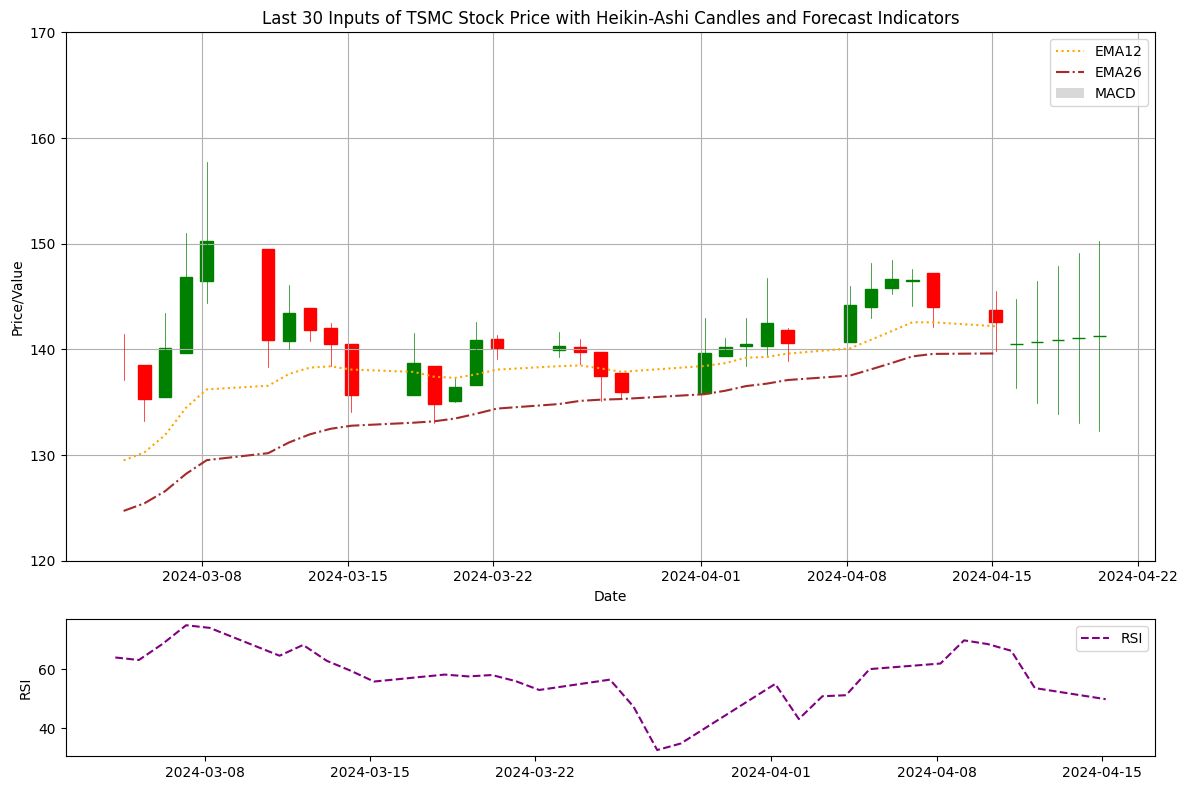

In [99]:
df_last_30 = df_tsm_clean.tail(30)

forecast_df['Date'] = forecast_df.index
forecast_df['Date'] = forecast_df['Date'].apply(mdates.date2num)

forecast_candles = pd.DataFrame({
    'Date': forecast_df['Date'],
    'Open': forecast_df['Forecast'],
    'High': forecast_df['Upper_95%'],
    'Low': forecast_df['Lower_95%'],
    'Close': forecast_df['Forecast']
})

full_candles = pd.concat([df_ha, forecast_candles])

plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax1.xaxis_date()
ax1.grid(True)
ax1.set_ylim(120, 170) 

candlestick_ohlc(ax1, full_candles.values, width=0.6, colorup='green', colordown='red', alpha=1)

plt.plot(df_last_30.index, df_last_30['ema_12'].tail(30), label='EMA12', color='orange', linestyle='dotted')
plt.plot(df_last_30.index, df_last_30['ema_26'].tail(30), label='EMA26', color='brown', linestyle='dashdot')
plt.bar(df_last_30.index, df_last_30['macd_line'].tail(30), label='MACD', color='gray', alpha=0.3)

plt.title('Last 30 Inputs of TSMC Stock Price with Heikin-Ashi Candles and Forecast Indicators')
plt.xlabel('Date')
plt.ylabel('Price/Value')
plt.legend()

ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
ax2.bar(df_last_30.index, df_last_30['Volume'].tail(30), color='blue', alpha=0.5)
ax2.grid(True)
plt.ylabel('Volume') 

ax3 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
ax3.plot(df_last_30.index, df_last_30['rsi'].tail(30), label='RSI', color='purple', linestyle='dashed')
ax3.legend()
ax3.set_ylabel('RSI')

plt.tight_layout()
plt.show()

In [30]:
last_date = df_tsm_clean.index[-1]

forecast_dates_arima = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=5, freq='D')

forecast_with_dates_arima = pd.DataFrame({'Forecast': forecast_values_arima}, index=forecast_dates_arima)
print(forecast_with_dates_arima)

                       Forecast
2024-04-16 04:00:00  140.528537
2024-04-17 04:00:00  140.726262
2024-04-18 04:00:00  140.908068
2024-04-19 04:00:00  141.092736
2024-04-20 04:00:00  141.277388


C:\Users\gijsv\AppData\Local\Temp\ipykernel_14008\3827862320.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((4, 1), (3, 0), sharex=ax1, rowspan=1)


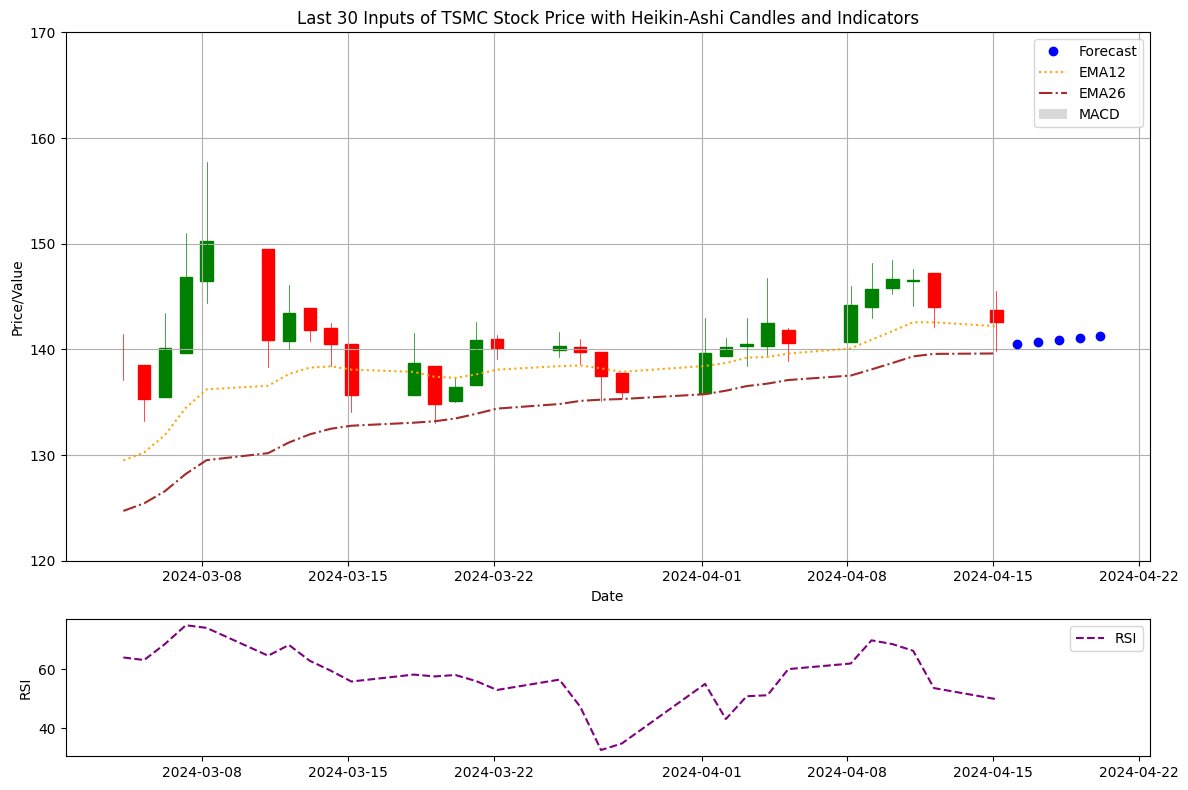

In [33]:
df_tsm_clean.index = pd.to_datetime(df_tsm_clean.index)

df_last_30 = df_tsm_clean.tail(30)

ha_close = (df_last_30['Open'] + df_last_30['High'] + df_last_30['Low'] + df_last_30['Close']) / 4
ha_open = (df_last_30['Open'].shift(1) + df_last_30['Close'].shift(1)) / 2
ha_high = df_last_30[['High', 'Open', 'Close']].max(axis=1)
ha_low = df_last_30[['Low', 'Open', 'Close']].min(axis=1)


df_ha = pd.DataFrame({'Date': df_last_30.index,
                      'Open': ha_open,
                      'High': ha_high,
                      'Low': ha_low,
                      'Close': ha_close})


plt.figure(figsize=(12, 8))


ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax1.xaxis_date()
ax1.grid(True)
ax1.set_ylim(120, 170)

df_ha['Date'] = df_ha['Date'].apply(mdates.date2num)

candlestick_ohlc(ax1, df_ha.values, width=0.6, colorup='green', colordown='red', alpha=1)

plt.plot(forecast_dates_arima, forecast_with_dates_arima['Forecast'], marker='o', color='blue', linestyle='None', label='Forecast')

# plt.plot(df_last_30.index, df_last_30['rsi'].tail(30), label='RSI', color='purple', linestyle='dashed')
plt.plot(df_last_30.index, df_last_30['ema_12'].tail(30), label='EMA12', color='orange', linestyle='dotted')
plt.plot(df_last_30.index, df_last_30['ema_26'].tail(30), label='EMA26', color='brown', linestyle='dashdot')
plt.bar(df_last_30.index, df_last_30['macd_line'].tail(30), label='MACD', color='gray', alpha=0.3)

plt.title('Last 30 Inputs of TSMC Stock Price with Heikin-Ashi Candles and Indicators')
plt.xlabel('Date')
plt.ylabel('Price/Value')
plt.legend()

ax2 = plt.subplot2grid((4, 1), (3, 0), sharex=ax1, rowspan=1)
ax2.bar(df_last_30.index, df_last_30['Volume'].tail(30), color='blue', alpha=0.5)
ax2.grid(True)
plt.ylabel('Volume') 

ax3 = plt.subplot2grid((4, 1), (3, 0), sharex=ax1, rowspan=1)

ax3.plot(df_last_30.index, df_last_30['rsi'].tail(30), label='RSI', color='purple', linestyle='dashed')

ax3.legend()
ax3.set_ylabel('RSI')
plt.tight_layout()

plt.show()

# SARIMA 12

In [35]:
s = 12
model_sarima_12 = auto_arima(df_close, seasonal=True, m=s, max_order=None)
model_sarima_12

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

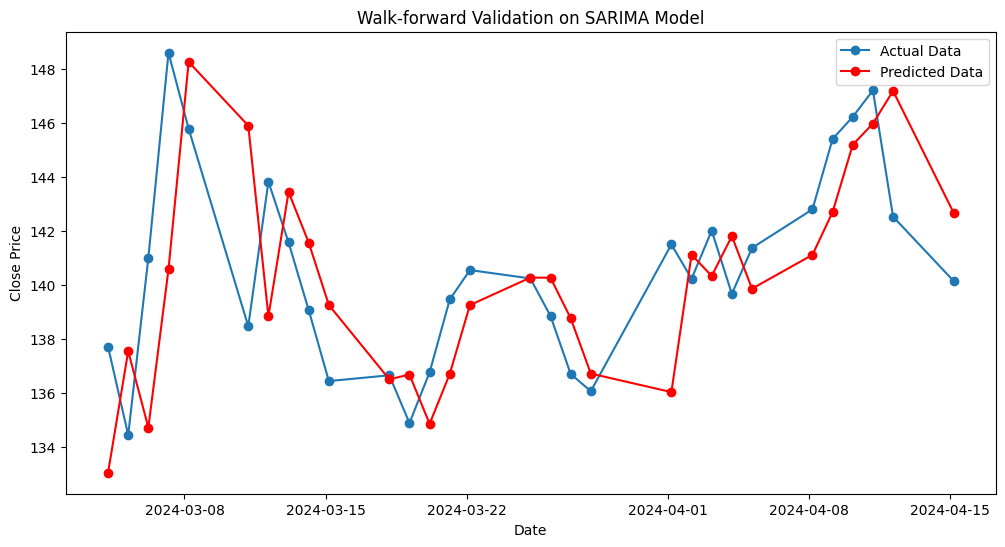

MSE: 11.461461715188042


In [44]:
df_tsm_clean.index = pd.to_datetime(df_tsm_clean.index)
df_tsm_clean = df_tsm_clean.sort_index()

n_test = 30
train_data = df_tsm_clean['Close'].iloc[:-n_test]
test_data = df_tsm_clean['Close'].iloc[-n_test:]
dates = df_tsm_clean.index[-n_test:] 

history = train_data.copy()
predictions = []
for t in range(n_test):
    model = SARIMAX(history, order=(0, 1, 2), seasonal_order=(1, 0, 1, 12))
    model_fit = model.fit(disp=False)
    output = model_fit.forecast()
    yhat = output.iloc[0]
    predictions.append(yhat)
    obs = test_data.iloc[t]

    new_index = [dates[t]]
    history = pd.concat([history, pd.Series([obs], index=new_index)])

plt.figure(figsize=(12, 6))
plt.plot(dates, test_data, label='Actual Data', marker='o')
plt.plot(dates, predictions, color='red', label='Predicted Data', marker='o')
plt.legend()
plt.title("Walk-forward Validation on SARIMA Model")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

mse = mean_squared_error(test_data, predictions)
print('MSE:', mse)

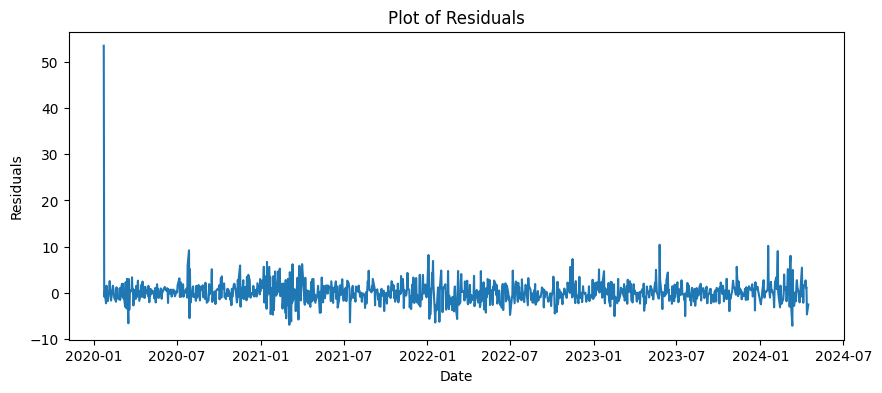

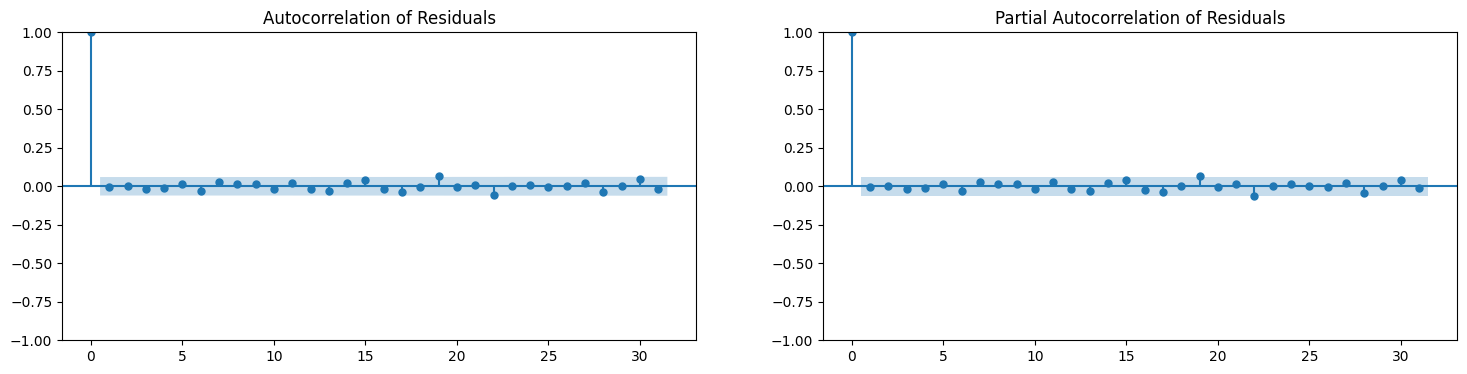

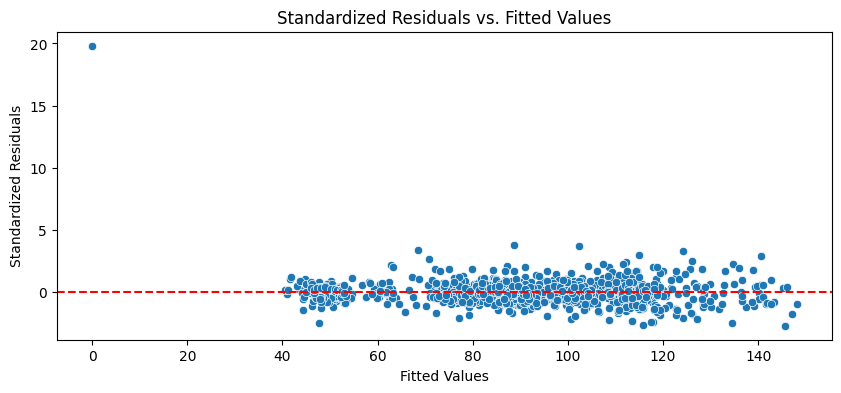

Forecasted values: [140.20902725537408, 140.05755232068756, 140.02111187539887, 140.05884503001485, 139.99755354297235]


In [45]:
order = (0, 1, 2)
seasonal_order = (1, 0, 1, 12)
model_sarimax_12 = SARIMAX(df_tsm_clean['Close'], order=order, seasonal_order=seasonal_order)
model_fit_sarima_12 = model_sarimax_12.fit()

residuals = model_fit_sarima_12.resid

# Plot of residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Plot of Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# ACF and PACF of residuals
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
plot_acf(residuals, ax=ax[0], title='Autocorrelation of Residuals')
plot_pacf(residuals, ax=ax[1], title='Partial Autocorrelation of Residuals')
plt.show()

# Standardized residuals vs. fitted values
fitted_values = model_fit_sarima_12.fittedvalues
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

plt.figure(figsize=(10, 4))
sns.scatterplot(x=fitted_values, y=standardized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Standardized Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')
plt.show()

forecast_sarima_12 = model_fit_sarima_12.forecast(steps=5)
forecast_values_sarima_12 = forecast_sarima_12.tolist()
print("Forecasted values:", forecast_values_sarima_12)

In [93]:
forecast_result = model_fit_sarima_12.get_forecast(steps=5)

mean_forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

forecast_df = pd.DataFrame({
    'Forecast': mean_forecast,
    'Lower_95%': conf_int.iloc[:, 0],
    'Upper_95%': conf_int.iloc[:, 1]
})
forecast_df.index = pd.date_range(start=df_tsm_clean.index[-1], periods=6, freq=df_tsm_clean.index.freq)[1:]
forecast_df

,Forecast,Lower_95%,Upper_95%
2024-04-16 04:00:00,140.209027,136.011351,144.406703
2024-04-17 04:00:00,140.057552,134.289676,145.825429
2024-04-18 04:00:00,140.021112,133.033535,147.008688
2024-04-19 04:00:00,140.058845,132.034877,148.082813
2024-04-20 04:00:00,139.997554,131.056531,148.938576


C:\Users\gijsv\AppData\Local\Temp\ipykernel_14008\3926957501.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)


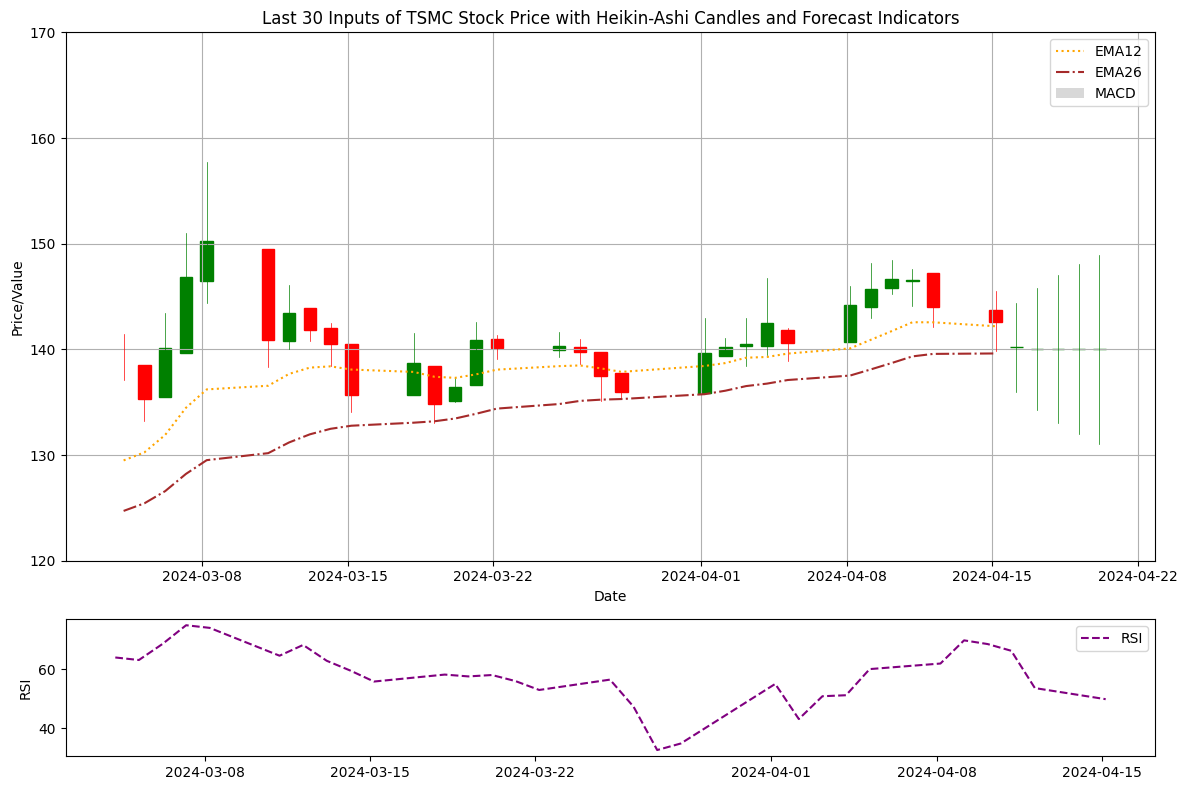

In [94]:
forecast_df['Date'] = forecast_df.index
forecast_df['Date'] = forecast_df['Date'].apply(mdates.date2num)

forecast_candles = pd.DataFrame({
    'Date': forecast_df['Date'],
    'Open': forecast_df['Forecast'],
    'High': forecast_df['Upper_95%'],
    'Low': forecast_df['Lower_95%'],
    'Close': forecast_df['Forecast']
})

full_candles = pd.concat([df_ha, forecast_candles])

plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax1.xaxis_date()
ax1.grid(True)
ax1.set_ylim(120, 170) 

candlestick_ohlc(ax1, full_candles.values, width=0.6, colorup='green', colordown='red', alpha=1)

plt.plot(df_last_30.index, df_last_30['ema_12'].tail(30), label='EMA12', color='orange', linestyle='dotted')
plt.plot(df_last_30.index, df_last_30['ema_26'].tail(30), label='EMA26', color='brown', linestyle='dashdot')
plt.bar(df_last_30.index, df_last_30['macd_line'].tail(30), label='MACD', color='gray', alpha=0.3)

plt.title('Last 30 Inputs of TSMC Stock Price with Heikin-Ashi Candles and Forecast Indicators')
plt.xlabel('Date')
plt.ylabel('Price/Value')
plt.legend()

ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
ax2.bar(df_last_30.index, df_last_30['Volume'].tail(30), color='blue', alpha=0.5)
ax2.grid(True)
plt.ylabel('Volume') 

ax3 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
ax3.plot(df_last_30.index, df_last_30['rsi'].tail(30), label='RSI', color='purple', linestyle='dashed')
ax3.legend()
ax3.set_ylabel('RSI')

plt.tight_layout()
plt.show()

In [46]:
last_date = df_tsm_clean.index[-1]

forecast_dates_sarima_12 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=5, freq='D')

forecast_with_dates_sarima_12 = pd.DataFrame({'Forecast': forecast_values_sarima_12}, index=forecast_dates_sarima_12)
print(forecast_with_dates_sarima_12)

                       Forecast
2024-04-16 04:00:00  140.209027
2024-04-17 04:00:00  140.057552
2024-04-18 04:00:00  140.021112
2024-04-19 04:00:00  140.058845
2024-04-20 04:00:00  139.997554


C:\Users\gijsv\AppData\Local\Temp\ipykernel_14008\1503789447.py:45: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((4, 1), (3, 0), sharex=ax1, rowspan=1)


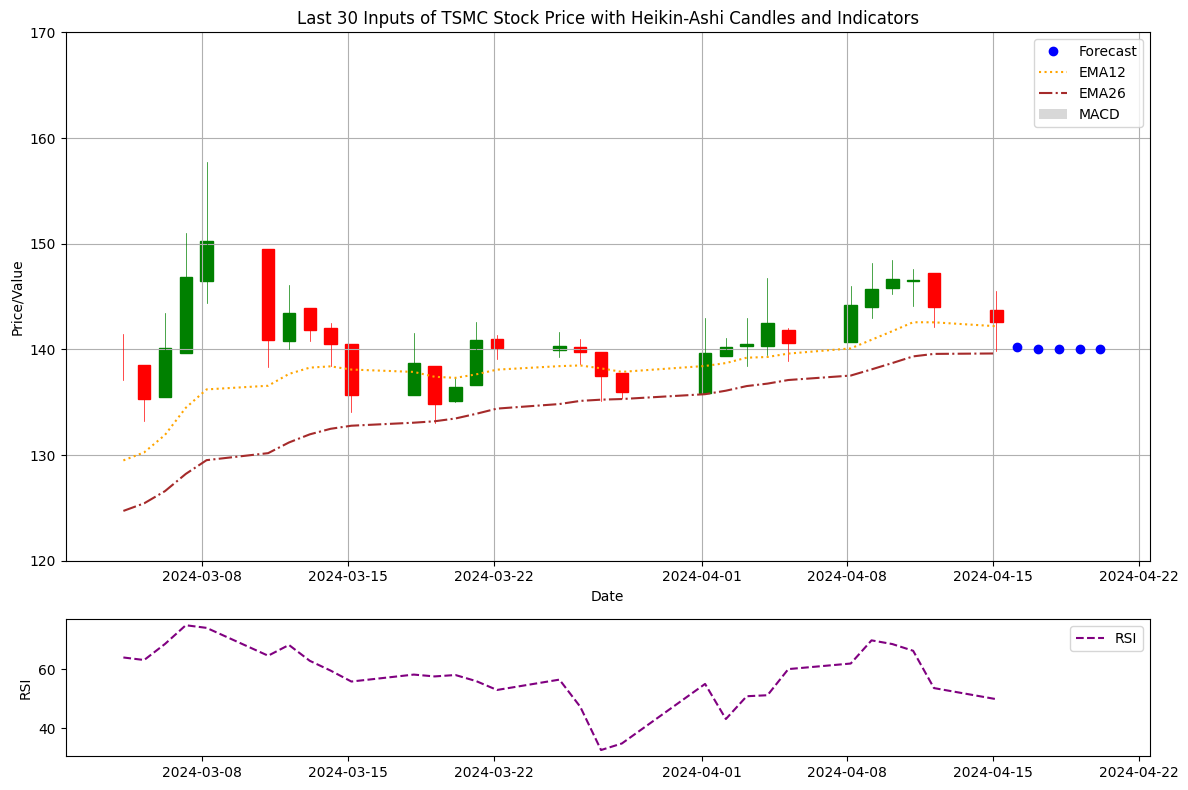

In [48]:
df_tsm_clean.index = pd.to_datetime(df_tsm_clean.index)

df_last_30 = df_tsm_clean.tail(30)

ha_close = (df_last_30['Open'] + df_last_30['High'] + df_last_30['Low'] + df_last_30['Close']) / 4
ha_open = (df_last_30['Open'].shift(1) + df_last_30['Close'].shift(1)) / 2
ha_high = df_last_30[['High', 'Open', 'Close']].max(axis=1)
ha_low = df_last_30[['Low', 'Open', 'Close']].min(axis=1)


df_ha = pd.DataFrame({'Date': df_last_30.index,
                      'Open': ha_open,
                      'High': ha_high,
                      'Low': ha_low,
                      'Close': ha_close})

plt.figure(figsize=(12, 8))

ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax1.xaxis_date()
ax1.grid(True)
ax1.set_ylim(120, 170)

df_ha['Date'] = df_ha['Date'].apply(mdates.date2num)

candlestick_ohlc(ax1, df_ha.values, width=0.6, colorup='green', colordown='red', alpha=1)

plt.plot(forecast_dates_sarima_12, forecast_with_dates_sarima_12['Forecast'], marker='o', color='blue', linestyle='None', label='Forecast')

# plt.plot(df_last_30.index, df_last_30['rsi'].tail(30), label='RSI', color='purple', linestyle='dashed')
plt.plot(df_last_30.index, df_last_30['ema_12'].tail(30), label='EMA12', color='orange', linestyle='dotted')
plt.plot(df_last_30.index, df_last_30['ema_26'].tail(30), label='EMA26', color='brown', linestyle='dashdot')
plt.bar(df_last_30.index, df_last_30['macd_line'].tail(30), label='MACD', color='gray', alpha=0.3)

plt.title('Last 30 Inputs of TSMC Stock Price with Heikin-Ashi Candles and Indicators')
plt.xlabel('Date')
plt.ylabel('Price/Value')
plt.legend()

ax2 = plt.subplot2grid((4, 1), (3, 0), sharex=ax3, rowspan=1)
ax2.bar(df_last_30.index, df_last_30['Volume'].tail(30), color='blue', alpha=0.5)
ax2.grid(True)
plt.ylabel('Volume') 

ax3 = plt.subplot2grid((4, 1), (3, 0), sharex=ax1, rowspan=1)

ax3.plot(df_last_30.index, df_last_30['rsi'].tail(30), label='RSI', color='purple', linestyle='dashed')

ax3.legend()
ax3.set_ylabel('RSI')
plt.tight_layout()

plt.show()

# SARIMA 4

In [49]:
s = 4
model_sarima_4 = auto_arima(df_close, seasonal=True, m=s, max_order=None)
model_sarima_4

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 4),
      suppress_warnings=True, with_intercept=False)

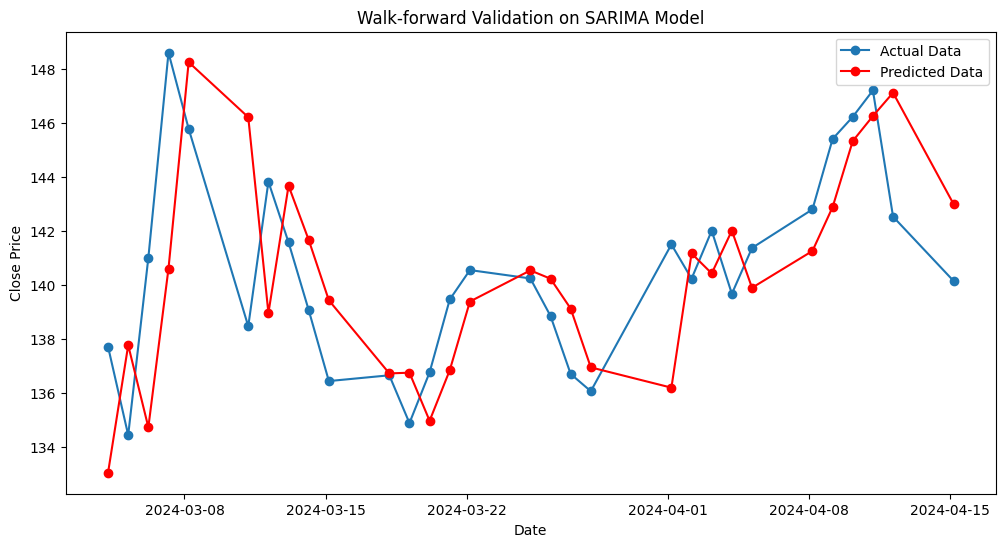

MSE: 11.630424890119704


In [60]:
df_tsm_clean.index = pd.to_datetime(df_tsm_clean.index)
df_tsm_clean = df_tsm_clean.sort_index()

n_test = 30
train_data = df_tsm_clean['Close'].iloc[:-n_test]
test_data = df_tsm_clean['Close'].iloc[-n_test:]
dates = df_tsm_clean.index[-n_test:] 

history = train_data.copy()
predictions = []
for t in range(n_test):
    model = SARIMAX(history, order=(0, 1, 2), seasonal_order=(0, 1, 1, 4))
    model_fit = model.fit(disp=False)
    output = model_fit.forecast()
    yhat = output.iloc[0]
    predictions.append(yhat)
    obs = test_data.iloc[t]

    new_index = [dates[t]]
    history = pd.concat([history, pd.Series([obs], index=new_index)])

plt.figure(figsize=(12, 6))
plt.plot(dates, test_data, label='Actual Data', marker='o')
plt.plot(dates, predictions, color='red', label='Predicted Data', marker='o')
plt.legend()
plt.title("Walk-forward Validation on SARIMA Model")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

mse = mean_squared_error(test_data, predictions)
print('MSE:', mse)

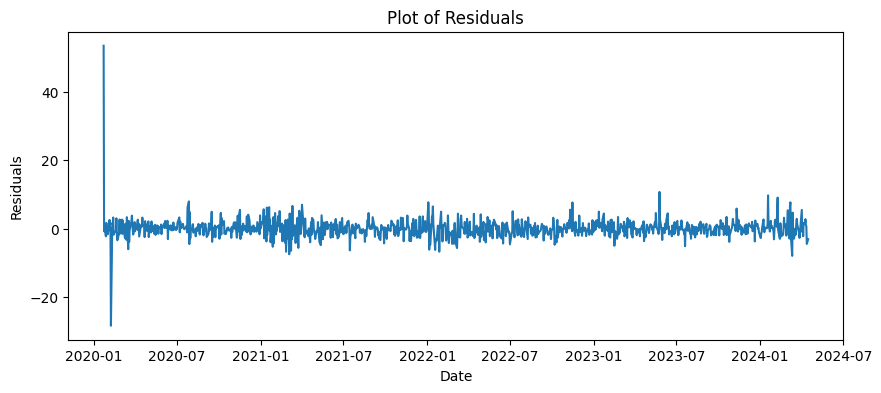

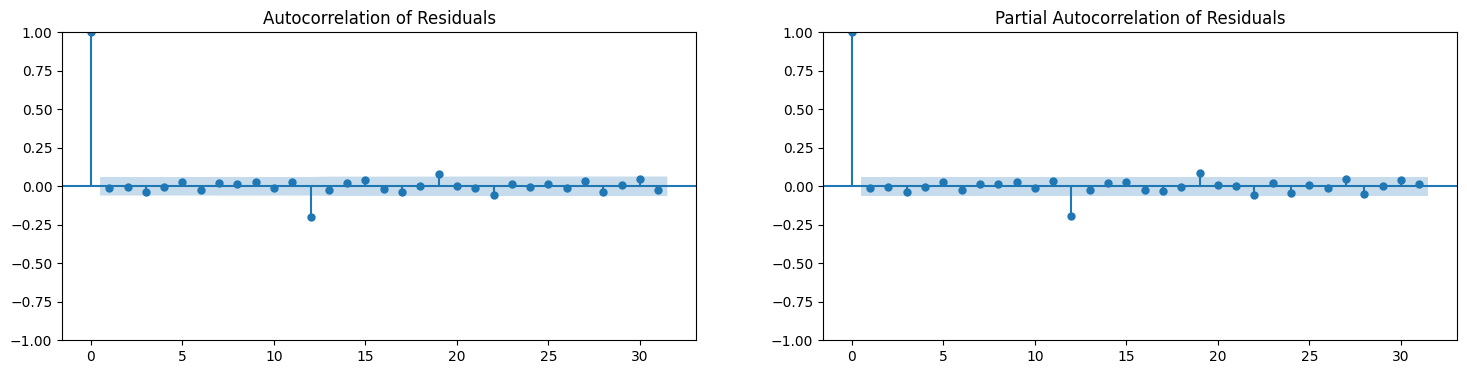

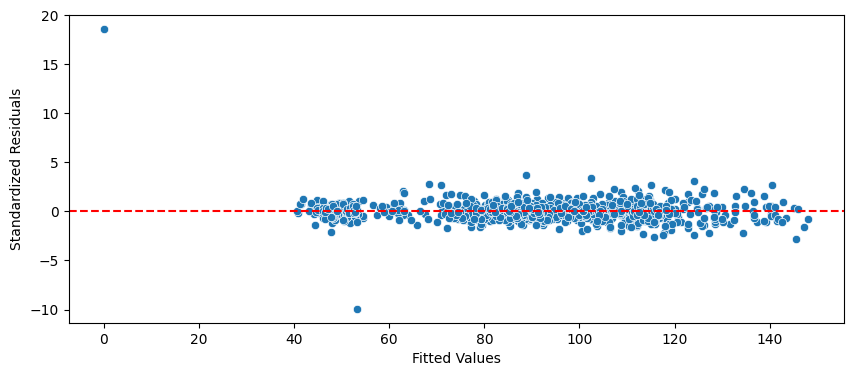

Forecasted values: [140.61978454783966, 140.59091772510538, 140.60075706181186, 140.74959993869874, 140.70121566369508]


In [74]:
order = (0, 1, 2)
seasonal_order = (0, 1, 1, 12)
model_sarimax_4 = SARIMAX(df_tsm_clean['Close'], order=order, seasonal_order=seasonal_order)
model_fit_sarima_4 = model_sarimax_4.fit()

residuals = model_fit_sarima_4.resid

plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Plot of Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(18, 4))
plot_acf(residuals, ax=ax[0], title='Autocorrelation of Residuals')
plot_pacf(residuals, ax=ax[1], title='Partial Autocorrelation of Residuals')
plt.show()

fitted_values = model_fit_sarima_12.fittedvalues
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

plt.figure(figsize=(10, 4))
sns.scatterplot(x=fitted_values, y=standardized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')
plt.show()

forecast_sarima_4 = model_fit_sarima_4.forecast(steps=5)
forecast_values_sarima_4 = forecast_sarima_4.tolist()
print("Forecasted values:", forecast_values_sarima_4)

In [87]:
forecast_result = model_fit_sarima_4.get_forecast(steps=5)

mean_forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

forecast_df = pd.DataFrame({
    'Forecast': mean_forecast,
    'Lower_95%': conf_int.iloc[:, 0],
    'Upper_95%': conf_int.iloc[:, 1]
})
forecast_df.index = pd.date_range(start=df_tsm_clean.index[-1], periods=6, freq=df_tsm_clean.index.freq)[1:]
forecast_df

,Forecast,Lower_95%,Upper_95%
2024-04-16 04:00:00,140.619785,136.387245,144.852324
2024-04-17 04:00:00,140.590918,134.773402,146.408434
2024-04-18 04:00:00,140.600757,133.559464,147.642050
2024-04-19 04:00:00,140.749600,132.667761,148.831439
2024-04-20 04:00:00,140.701216,131.698413,149.704019


C:\Users\gijsv\AppData\Local\Temp\ipykernel_14008\4114110735.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)


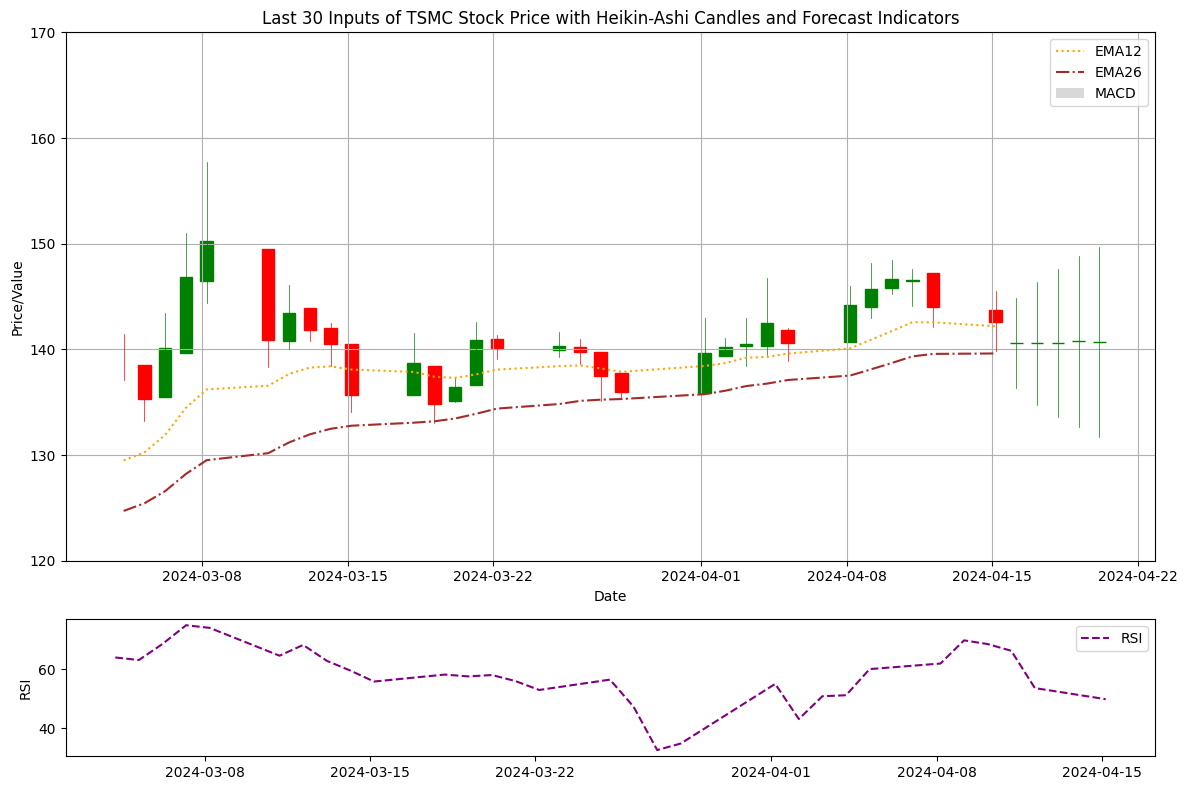

In [92]:
forecast_df['Date'] = forecast_df.index
forecast_df['Date'] = forecast_df['Date'].apply(mdates.date2num)

forecast_candles = pd.DataFrame({
    'Date': forecast_df['Date'],
    'Open': forecast_df['Forecast'],
    'High': forecast_df['Upper_95%'],
    'Low': forecast_df['Lower_95%'],
    'Close': forecast_df['Forecast']
})

full_candles = pd.concat([df_ha, forecast_candles])

plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax1.xaxis_date()
ax1.grid(True)
ax1.set_ylim(120, 170) 

candlestick_ohlc(ax1, full_candles.values, width=0.6, colorup='green', colordown='red', alpha=1)

plt.plot(df_last_30.index, df_last_30['ema_12'].tail(30), label='EMA12', color='orange', linestyle='dotted')
plt.plot(df_last_30.index, df_last_30['ema_26'].tail(30), label='EMA26', color='brown', linestyle='dashdot')
plt.bar(df_last_30.index, df_last_30['macd_line'].tail(30), label='MACD', color='gray', alpha=0.3)

plt.title('Last 30 Inputs of TSMC Stock Price with Heikin-Ashi Candles and Forecast Indicators')
plt.xlabel('Date')
plt.ylabel('Price/Value')
plt.legend()

ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
ax2.bar(df_last_30.index, df_last_30['Volume'].tail(30), color='blue', alpha=0.5)
ax2.grid(True)
plt.ylabel('Volume') 

ax3 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
ax3.plot(df_last_30.index, df_last_30['rsi'].tail(30), label='RSI', color='purple', linestyle='dashed')
ax3.legend()
ax3.set_ylabel('RSI')

plt.tight_layout()
plt.show()


In [61]:
last_date = df_tsm_clean.index[-1]

forecast_dates_sarima_4 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=5, freq='D')

forecast_with_dates_sarima_4 = pd.DataFrame({'Forecast': forecast_values_sarima_4}, index=forecast_dates_sarima_4)
print(forecast_with_dates_sarima_4)

                       Forecast
2024-04-16 04:00:00  140.619785
2024-04-17 04:00:00  140.590918
2024-04-18 04:00:00  140.600757
2024-04-19 04:00:00  140.749600
2024-04-20 04:00:00  140.701216


C:\Users\gijsv\AppData\Local\Temp\ipykernel_14008\1113902659.py:45: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((4, 1), (3, 0), sharex=ax1, rowspan=1)


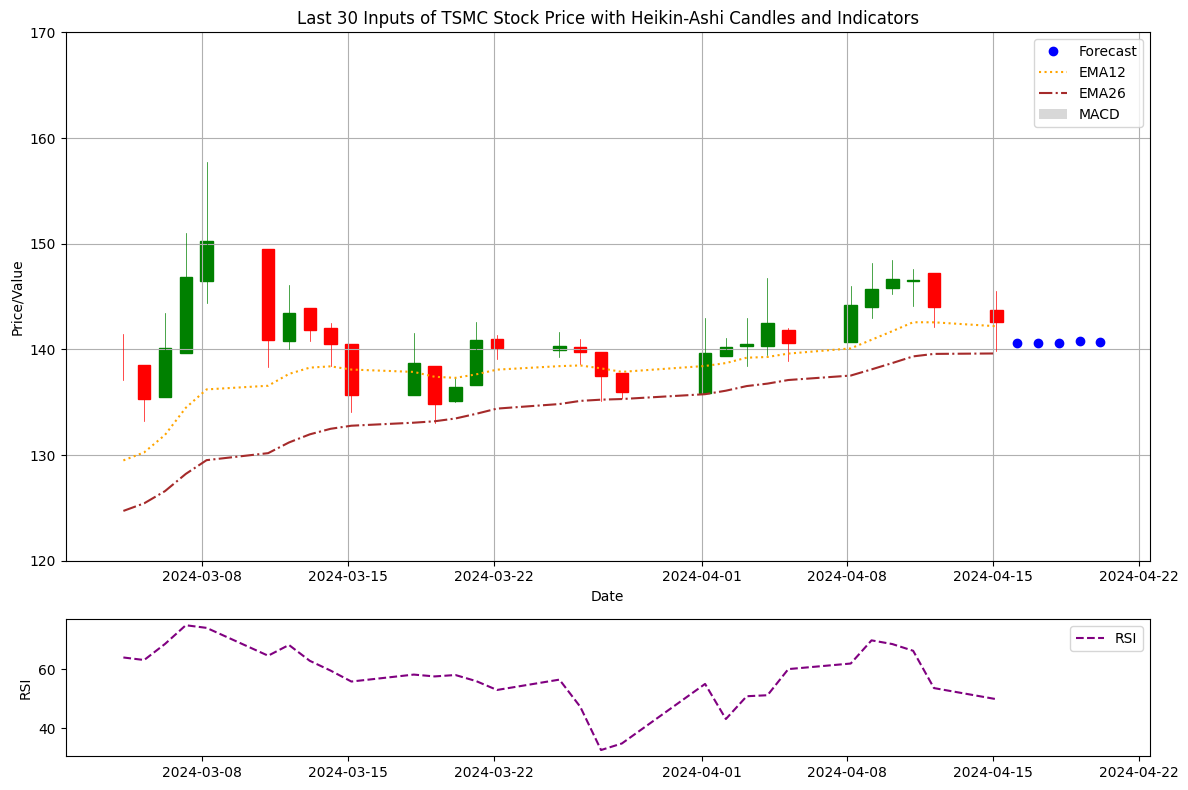

In [63]:
df_tsm_clean.index = pd.to_datetime(df_tsm_clean.index)

df_last_30 = df_tsm_clean.tail(30)

ha_close = (df_last_30['Open'] + df_last_30['High'] + df_last_30['Low'] + df_last_30['Close']) / 4
ha_open = (df_last_30['Open'].shift(1) + df_last_30['Close'].shift(1)) / 2
ha_high = df_last_30[['High', 'Open', 'Close']].max(axis=1)
ha_low = df_last_30[['Low', 'Open', 'Close']].min(axis=1)


df_ha = pd.DataFrame({'Date': df_last_30.index,
                      'Open': ha_open,
                      'High': ha_high,
                      'Low': ha_low,
                      'Close': ha_close})

plt.figure(figsize=(12, 8))

ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax1.xaxis_date()
ax1.grid(True)
ax1.set_ylim(120, 170)

df_ha['Date'] = df_ha['Date'].apply(mdates.date2num)

candlestick_ohlc(ax1, df_ha.values, width=0.6, colorup='green', colordown='red', alpha=1)

plt.plot(forecast_dates_sarima_4, forecast_with_dates_sarima_4['Forecast'], marker='o', color='blue', linestyle='None', label='Forecast')

# plt.plot(df_last_30.index, df_last_30['rsi'].tail(30), label='RSI', color='purple', linestyle='dashed')
plt.plot(df_last_30.index, df_last_30['ema_12'].tail(30), label='EMA12', color='orange', linestyle='dotted')
plt.plot(df_last_30.index, df_last_30['ema_26'].tail(30), label='EMA26', color='brown', linestyle='dashdot')
plt.bar(df_last_30.index, df_last_30['macd_line'].tail(30), label='MACD', color='gray', alpha=0.3)

plt.title('Last 30 Inputs of TSMC Stock Price with Heikin-Ashi Candles and Indicators')
plt.xlabel('Date')
plt.ylabel('Price/Value')
plt.legend()

ax2 = plt.subplot2grid((4, 1), (3, 0), sharex=ax3, rowspan=1)
ax2.bar(df_last_30.index, df_last_30['Volume'].tail(30), color='blue', alpha=0.5)
ax2.grid(True)
plt.ylabel('Volume') 

ax3 = plt.subplot2grid((4, 1), (3, 0), sharex=ax1, rowspan=1)

ax3.plot(df_last_30.index, df_last_30['rsi'].tail(30), label='RSI', color='purple', linestyle='dashed')

ax3.legend()
ax3.set_ylabel('RSI')
plt.tight_layout()

plt.show()